# Computational Efficiency of Peridynamics

In [1]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
import PeriFlakes

## Data Access Patterns

## Horizon size

In the cornflakes graph representation, each edge contains the data vertex for the center point of the horizon, the neighbor points, and the bonds to the neighbors. The edges are stored like
> Pt0 Pt1 Pt2... PtN Bond1 Bond2 ... BondN

so that the total length of the edge is 
\begin{equation}
L_{edge}=2 N_{neighbor}+1
\end{equation}
Let us examine how the stencil size, the number of neighbors plus one, depends on the relative horizon size, $RF=\delta/h$

In [2]:
for RF in [1.5,2.0,2.5,3.0,3.5]:
    PB = PeriFlakes.PeriBlock(1,10,RF*2.0/10.0)
    print RF,
    for l in PB.HAdj.view():
        print ((l.shape[-1]-1)/2)+1,
    print

1.5 4 6 9
2.0 4 6 9
2.5 8 11 13 15 18 21
3.0 9 12 15 16 20 25
3.5 13 17 20 22 26 29 31 34 37


Not every point has the same amount of points in its horizon; along the edges the points have smaller supports. For example, in the smallest case the corners only have four points in their horizon. Let us not concern ourselves with that means right now, and only look at the maximum value, which corresponds to the points whose horizons are fully contained in the domain.

1.5 9
1.625 9
1.75 9
1.875 13
2.0 13
2.125 21
2.25 21
2.375 21
2.5 21
2.625 25
2.75 25
2.875 29
3.0 37
3.125 37
3.25 37
3.375 45
3.5 45
3.625 45
3.75 49
3.875 57
4.0 61
4.125 61
4.25 69
4.375 69
4.5 69
4.625 69
4.75 89
4.875 89
5.0 97
5.125 97
5.25 101
5.375 101


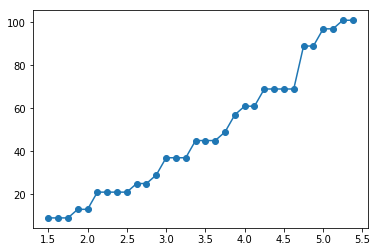

In [3]:
RFs = np.arange(1.5,5.5,0.125)
sups = []
for RF in RFs:
    PB = PeriFlakes.PeriBlock(1,50,RF*2.0/50.0)
    supsize = ((max([l.shape[-1] for l in PB.HAdj.view() ])-1)/2)+1
    #print RF,supsize
    sups.append(supsize)
plt.plot(RFs,sups,'-o')

So we see that the number of points in the support increases greatly as the support radius increases. The staircasing is due to the discrete nature of the grid. The numbers might be a little bit of an overestimate due to extra buffer-room when cornflakes performs the geometric search (i.e. some points may have a weight of 0 during the calculation). It's pretty obvious that the trend is quadritic in 2D, and will be cubic in 3D. 

**The relative horizon size controls an intrinsic properties of the numerical discretization that governs its quality.** Below a certain limit, the method is invalid, and as it increases, it becomes computationally inefficient. 

With more points in a support, the kernel calculation requires more data. This adversely affects the data access patterns of the program.

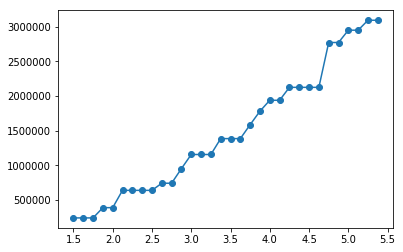

In [10]:
# This is a very expensive cell!
RFs = np.arange(1.5,5.5,0.125)
nnzs = []
for RF in RFs:
    PB = PeriFlakes.PeriBlock(1,50,RF*2.0/50.0)
    K,R = PB._assemble_KR('Silling','const')
    nnzs.append(K.nnz)
plt.plot(RFs,nnzs,'o-')

This number of nonzeros is more than just how much memory the matrix takes up. This is a representation of the data access patterns of the program. Even using a matrix-free solution method, the computational cost of the system of equations increases greatly. 

In [ ]:
RFs = np.arange(1.5,5.5,2.0)
for RF in RFs:
    PB = PeriFlakes.PeriBlock(1,10,RF*2.0/50.0)
    K,R = PB._assemble_KR('Silling','const')
    plt.spy(K)
    plt.show()

## The Finite Element Benchmark

In a finite element code, the equivalent to the horizon computational hypergraph is the element connectivity table. So, the equivalent of a list of points in a horizon is the list of nodes in an element. Again, this is governed by the data access pattern of the computer program: which data is the input to the unit kernel of the numerical method. 

FEniCS isn't included in the cornflakes image, so I will just do some of the math by hand here, and then load anoher csv file from an experiment in the file [fenics_nnz.py](fenics_nnz.py).
(TODO maybe I should put an FEM example into cornflakes?)